In [16]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 200
import Preprocessing
import Settings
import Sampling
import VideoAnalysis

In [2]:
dataFile = Preprocessing.listDataFiles(excludeDataWithoutMovies=True)[0]

propertyFile = Preprocessing.loadRunData(dataFile)
video = Preprocessing.loadVideo(dataFile)
matFile = Preprocessing.loadMatFile(dataFile)

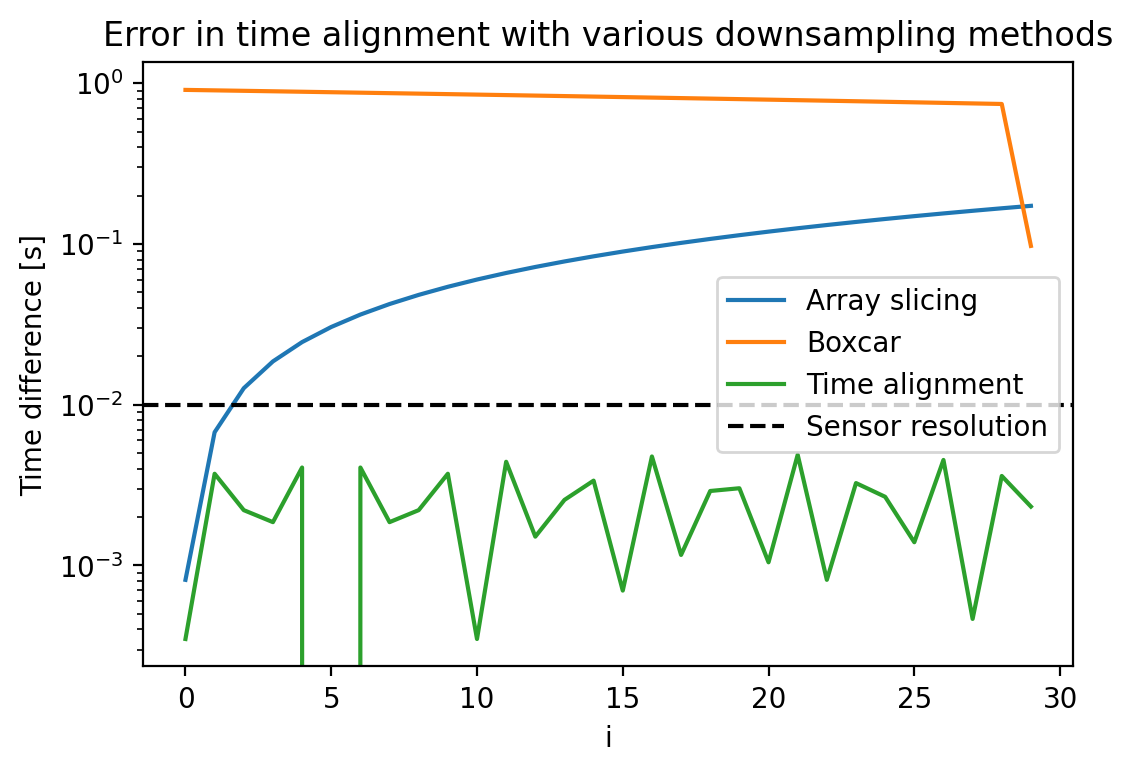

In [19]:
downsampleMethods = [Sampling.sliceDownsample, Sampling.boxcarDownsample, Sampling.timeAlignmentDownsample]
downsampleMethodNames = ["Array slicing", "Boxcar", "Time alignment"]

for i in range(3):
    tArr, sArr, fArr = Sampling.randomSample(video, propertyFile, matFile, VideoAnalysis.averageBrightness, downsampleMethod=downsampleMethods[i])
    plt.plot(abs(tArr-fArr), label=downsampleMethodNames[i])
    
plt.xlabel('i')
plt.ylabel('Time difference [s]')
plt.axhline(y=Settings.FORCE_SENSOR_DT, color='black', linestyle='--', label='Sensor resolution')
plt.axhline(y=-Settings.FORCE_SENSOR_DT, color='black', linestyle='--')

plt.legend()
plt.yscale('log')
plt.title('Error in time alignment with various downsampling methods')
plt.savefig('SamplingTest_images/downsample_time_error_all.png')
plt.show()

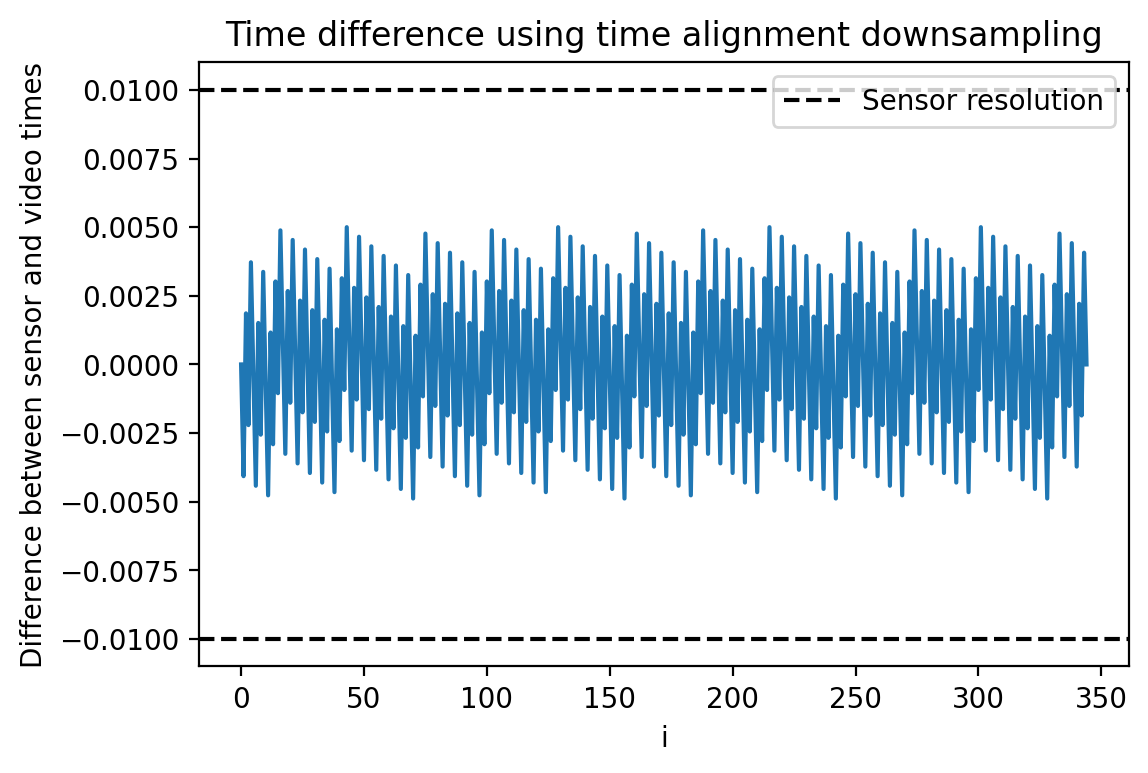

In [20]:
sensorTimeArr = matFile["t"]
sensorForceArr = matFile["f"]
videoTimeArr = VideoAnalysis.timeArr(video, propertyFile)
kernelGuess = int((videoTimeArr[1] - videoTimeArr[0])/Settings.FORCE_SENSOR_DT)

downsampledTimeArr = Sampling.timeAlignmentDownsample(sensorTimeArr, sensorForceArr, videoTimeArr, kernelGuess, debug=True)[0]

#print(downsampledTimeArr)
plt.plot(videoTimeArr-downsampledTimeArr)
plt.axhline(y=Settings.FORCE_SENSOR_DT, color='black', linestyle='--', label='Sensor resolution')
plt.axhline(y=-Settings.FORCE_SENSOR_DT, color='black', linestyle='--')

plt.ylabel('Difference between sensor and video times')
plt.xlabel('i')
plt.legend()
plt.title('Time difference using time alignment downsampling')
plt.savefig('SamplingTest_images/downsample_time_error2.png')
plt.show()